# Financial Data Preprocessing and EDA

This notebook demonstrates data extraction, cleaning, EDA, and volatility analysis for TSLA, BND, and SPY using YFinance. Code is modular and OOP-based following best practices.

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from scipy.stats import zscore

sns.set(style='whitegrid')
%matplotlib inline

## OOP-based Data Loader and Preprocessor

In [3]:
class FinancialDataLoader:
    def __init__(self, tickers, start='2015-01-01', end=None):
        self.tickers = tickers
        self.start = start
        self.end = end
        self.data = None

    def download(self):
        self.data = yf.download(self.tickers, start=self.start, end=self.end, group_by='ticker', auto_adjust=True)
        return self.data

    def get_close(self):
        close_data = {}
        for ticker in self.tickers:
            close_data[ticker] = self.data[ticker]['Close']
        return pd.DataFrame(close_data)


In [4]:
class FinancialPreprocessor:
    def __init__(self, df):
        self.df = df.copy()

    def check_missing(self):
        return self.df.isnull().sum()

    def fill_missing(self, method='ffill'):
        self.df = self.df.fillna(method=method)
        return self.df

    def normalize(self):
        self.df = (self.df - self.df.mean()) / self.df.std()
        return self.df


## 1. Data Extraction

In [7]:
tickers = ['TSLA', 'BND', 'SPY']
loader = FinancialDataLoader(tickers, start='2018-01-01')
raw_data = loader.download()
close_df = loader.get_close()
close_df.head()

[*********************100%***********************]  3 of 3 completed


,TSLA,BND,SPY
Date,,,
2018-01-02,21.368668,65.400726,238.568634
2018-01-03,21.150000,65.457024,240.077713
2018-01-04,20.974667,65.424866,241.089584
2018-01-05,21.105333,65.336380,242.696228
2018-01-08,22.427334,65.344452,243.140015


## 2. Data Cleaning and Preprocessing

In [8]:
preprocessor = FinancialPreprocessor(close_df)
print('Missing values:')
display(preprocessor.check_missing())
clean_df = preprocessor.fill_missing()
clean_df = preprocessor.normalize()
clean_df.head()

Missing values:


TSLA    1
BND     0
SPY     0
dtype: int64

C:\Users\Eyoel\AppData\Local\Temp\ipykernel_41480\132362625.py:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.df = self.df.fillna(method=method)


,TSLA,BND,SPY
Date,,,
2018-01-02,-1.275783,-1.152670,-1.286539
2018-01-03,-1.277653,-1.138831,-1.273012
2018-01-04,-1.279153,-1.146736,-1.263943
2018-01-05,-1.278035,-1.168488,-1.249542
2018-01-08,-1.266728,-1.166503,-1.245564


## 3. Exploratory Data Analysis (EDA)

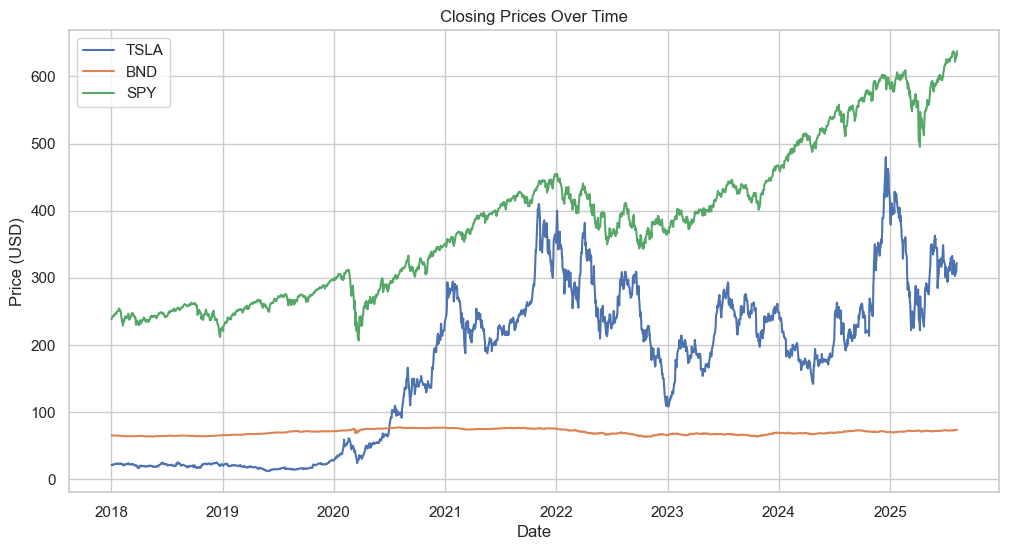

In [9]:
plt.figure(figsize=(12,6))
for ticker in tickers:
    plt.plot(close_df.index, close_df[ticker], label=ticker)
plt.title('Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

C:\Users\Eyoel\AppData\Local\Temp\ipykernel_41480\1073166796.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = close_df.pct_change().dropna()


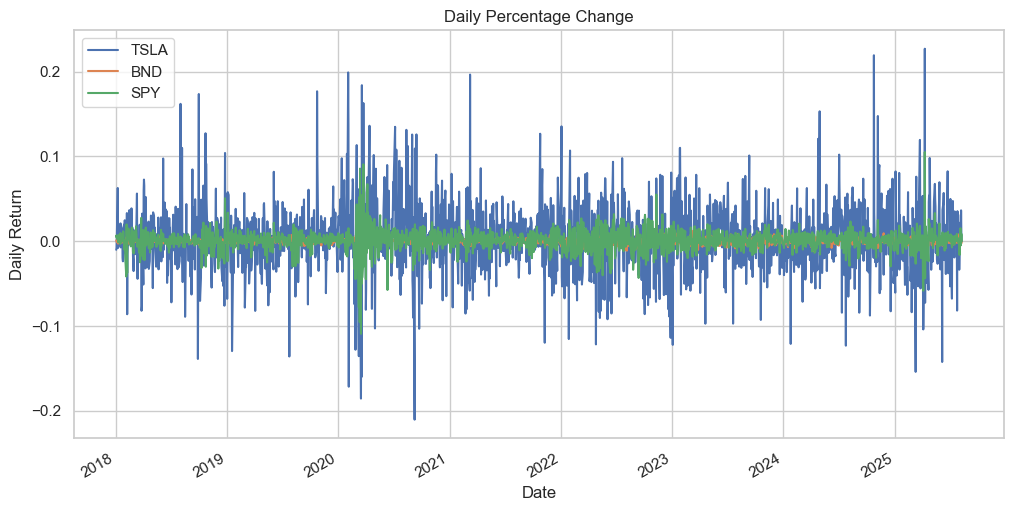

In [10]:
returns = close_df.pct_change().dropna()
returns.plot(figsize=(12,6))
plt.title('Daily Percentage Change')
plt.ylabel('Daily Return')
plt.show()

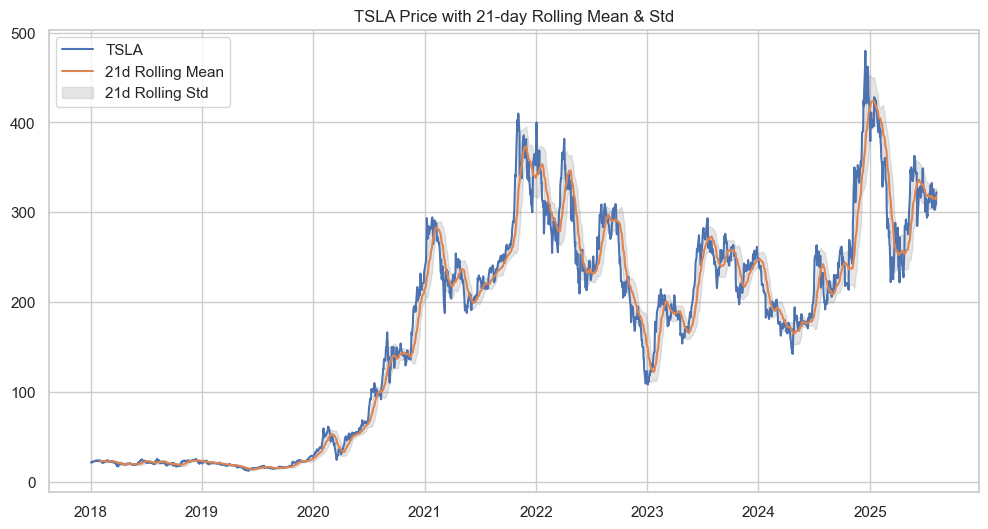

In [11]:
rolling_mean = close_df.rolling(window=21).mean()
rolling_std = close_df.rolling(window=21).std()
plt.figure(figsize=(12,6))
plt.plot(close_df.index, close_df['TSLA'], label='TSLA')
plt.plot(rolling_mean.index, rolling_mean['TSLA'], label='21d Rolling Mean')
plt.fill_between(rolling_std.index,
    rolling_mean['TSLA']-rolling_std['TSLA'],
    rolling_mean['TSLA']+rolling_std['TSLA'], color='gray', alpha=0.2, label='21d Rolling Std')
plt.title('TSLA Price with 21-day Rolling Mean & Std')
plt.legend()
plt.show()

### Outlier Detection (Z-score)

In [12]:
z_scores = np.abs(zscore(returns))
outliers = (z_scores > 3)
print('Number of outliers per ticker:')
print(outliers.sum())
returns[outliers.any(axis=1)]

Number of outliers per ticker:
84


,TSLA,BND,SPY
Date,,,
2018-02-05,-0.030895,0.004380,-0.041823
2018-02-08,-0.086290,-0.000751,-0.037509
2018-08-02,0.161880,0.000508,0.005448
2018-09-28,-0.139015,0.000000,0.000104
2018-10-01,0.173471,-0.001872,0.003474
...,...,...,...
2025-04-04,-0.104198,0.000813,-0.058543
2025-04-07,-0.025644,-0.012056,-0.001781
2025-04-09,0.226900,0.002345,0.105019


## 4. Stationarity Test (ADF)

In [13]:
for ticker in tickers:
    print(f'ADF Test for {ticker}:')
    result = adfuller(close_df[ticker].dropna())
    print(f'ADF Statistic: {result[0]:.4f}, p-value: {result[1]:.4f}')
    if result[1] < 0.05:
        print('Series is stationary.')
    else:
        print('Series is NOT stationary.')
    print('-'*30)

ADF Test for TSLA:
ADF Statistic: -1.7902, p-value: 0.3853
Series is NOT stationary.
------------------------------
ADF Test for BND:
ADF Statistic: -1.4775, p-value: 0.5446
Series is NOT stationary.
------------------------------
ADF Test for SPY:
ADF Statistic: 0.3336, p-value: 0.9788
Series is NOT stationary.
------------------------------


## 5. Volatility & Risk Metrics (VaR, Sharpe Ratio)

In [14]:
def value_at_risk(returns, confidence=0.05):
    return returns.quantile(confidence)

def sharpe_ratio(returns, risk_free_rate=0):
    return (returns.mean() - risk_free_rate) / returns.std() * np.sqrt(252)

for ticker in tickers:
    var = value_at_risk(returns[ticker])
    sharpe = sharpe_ratio(returns[ticker])
    print(f'{ticker} VaR (5%): {var:.4f}, Sharpe Ratio: {sharpe:.2f}')

TSLA VaR (5%): -0.0596, Sharpe Ratio: 0.88
BND VaR (5%): -0.0054, Sharpe Ratio: 0.28
SPY VaR (5%): -0.0185, Sharpe Ratio: 0.75


## 6. Key Insights
- TSLA shows higher volatility and potential returns compared to BND and SPY.
- BND provides portfolio stability with lower risk.
- SPY offers diversified exposure.
- Stationarity tests guide model selection for forecasting.
- Outliers and volatility metrics inform risk management.

*Continue to modeling and optimization in subsequent notebooks.*